# Comparing Machine Learning Models for Stock Market Price Prediction

**CS 5805: Machine Learning Final Project**

Pranesh Ambokar, Mohammed Heydari, Roshan Ravindran, and Leo St. Amour

## Overview

Present an overview of the problem and our experimental design.

## Environmental Setup

Import relevant libraries and describe the purposes of each

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data Preprocessing

Describe our data and the steps for preparing it for our specific application
- Load the data (individual CSV)
- Aggregate the data
- Scale the data
- Train/test/validation split

TODO: move sequence creation function for LSTM here; describe why LSTM need the data parsed into sequences

In [2]:
import glob

all_files = glob.glob('*.csv')
df_list = []

for csv in all_files:
    df = pd.read_csv(csv)
    df['Stock'] = csv.split('.')[0]
    df_list.append(df)
data = pd.concat(df_list, ignore_index=True)
data = data.sort_values(['Stock', 'Date'])

In [3]:
# Create training/validation/testing sets using a 70/15/15 split
training_data = []
validation_data = []
testing_data = []

for stock in data['Stock'].unique():
    stock_data = data[data['Stock'] == stock]
    train_size = int(len(stock_data) * 0.7)
    val_size = int(len(stock_data) * 0.15)
    
    # Split the data for each stock
    training_data.append(stock_data.iloc[:train_size])
    validation_data.append(stock_data.iloc[train_size:train_size+val_size])
    testing_data.append(stock_data.iloc[train_size+val_size:])

# Concatenate the split data
training_data = pd.concat(training_data, ignore_index=True)
validation_data = pd.concat(validation_data, ignore_index=True)
testing_data = pd.concat(testing_data, ignore_index=True)

# Define the features (Open, Low, High) and target (Close)
training_X = training_data[['Open', 'Low', 'High']]
training_Y = training_data[['Close']]
validation_X = validation_data[['Open', 'Low', 'High']]
validation_Y = validation_data[['Close']]
testing_X = testing_data[['Open', 'Low', 'High']]
testing_Y = testing_data[['Close']]

# Check the number of features in the training data
num_features = training_X.shape[1]

# Output the split data for verification
print(f"Training data: {len(training_data)} rows")
print(f"Validation data: {len(validation_data)} rows")
print(f"Testing data: {len(testing_data)} rows")

num_features = training_X.shape[1]

Training data: 21112 rows
Validation data: 4522 rows
Testing data: 4529 rows


In [4]:
from sklearn.preprocessing import MinMaxScaler

# Scale the data
scaler_X = MinMaxScaler(feature_range=(0, 1))  # For the features
scaler_Y = MinMaxScaler(feature_range=(0, 1))  # For the target (Close)

# Scale the features and target for training and testing sets
training_X_scaled = scaler_X.fit_transform(training_X)
testing_X_scaled = scaler_X.transform(testing_X)
validation_X_scaled = scaler_X.transform(validation_X)

# Scale the target variable (Close) for training and testing sets
training_Y_scaled = scaler_Y.fit_transform(training_Y)
testing_Y_scaled = scaler_Y.transform(testing_Y)
validation_Y_scaled = scaler_Y.transform(validation_Y)

## Linear Regression

In [5]:
%%time
from sklearn.linear_model import LinearRegression

linear_regression_model = LinearRegression()
linear_regression_model.fit(training_X_scaled, training_Y_scaled)

CPU times: user 36.7 ms, sys: 12.1 ms, total: 48.8 ms
Wall time: 47.9 ms


LinearRegression()

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score

def test_on_stock(model, stock_symbol, model_type='LR'):
    stock_data = testing_data[testing_data['Stock'] == stock_symbol]
    stock_X = stock_data[['Open', 'Low', 'High']]
    stock_Y = stock_data[['Close']]
    
    # Scale test data
    stock_X_scaled = scaler_X.transform(stock_X)
    stock_Y_scaled = scaler_Y.transform(stock_Y)

    if model_type == "LSTM":
        # Reshape stock_X_scaled to 3D array for LSTM (samples, time_steps, features)
        stock_X_scaled_3d = []
        for i in range(len(stock_X_scaled) - sequence_length):
            stock_X_scaled_3d.append(stock_X_scaled[i:i + sequence_length])
        stock_X_scaled_3d = np.array(stock_X_scaled_3d)
        
        # Make predictions using LSTM
        predictions_scaled = model.predict(stock_X_scaled_3d)
        
        # Inverse transform predictions and actual values to original scale
        predictions = scaler_Y.inverse_transform(predictions_scaled)
        actual_values = scaler_Y.inverse_transform(stock_Y_scaled[sequence_length:])

    else:
        # Make predictions
        predictions_scaled = model.predict(stock_X_scaled)
        predictions = scaler_Y.inverse_transform(predictions_scaled)
        actual_values = scaler_Y.inverse_transform(stock_Y_scaled)

    mse = mean_squared_error(actual_values, predictions)
    rmse = np.sqrt(mse)  # Root Mean Squared Error
    r2 = r2_score(actual_values, predictions)  # R² score

    print(f"Mean Squared Error for {stock_symbol}: {mse}")
    print(f"Root Mean Squared Error (RMSE) for {stock_symbol}: {rmse}")
    print(f"R² Score for {stock_symbol}: {r2}")

    # Plot actual vs predicted prices for visualization
    plt.plot(actual_values, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.legend()
    plt.title(f'{stock_symbol} - Actual vs Predicted Prices')
    plt.show()

Mean Squared Error for AAPL: 1.2624831495051836
Root Mean Squared Error (RMSE) for AAPL: 1.1236027543154135
R² Score for AAPL: 0.9995547690760687


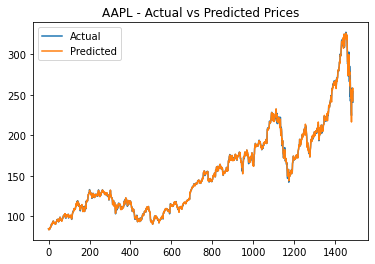

Mean Squared Error for AMZN: 96.01917965114241
Root Mean Squared Error (RMSE) for AMZN: 9.79893767972541
R² Score for AMZN: 0.9994439932045063


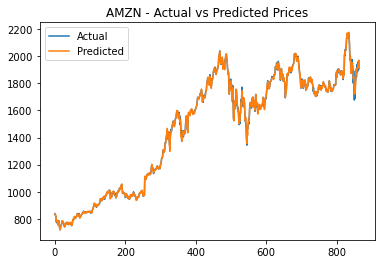

Mean Squared Error for FB: 1.7715246273688896
Root Mean Squared Error (RMSE) for FB: 1.3309863362818153
R² Score for FB: 0.9935954021523853


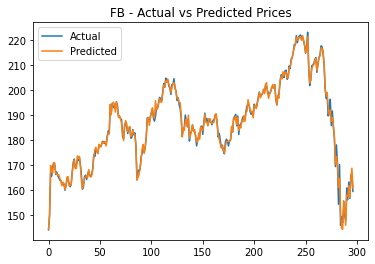

Mean Squared Error for GOOGL: 60.03699051380999
Root Mean Squared Error (RMSE) for GOOGL: 7.748354051913863
R² Score for GOOGL: 0.9951361122466904


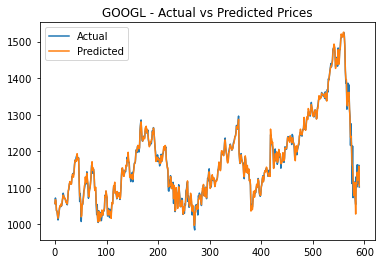

Mean Squared Error for MSFT: 0.4648107248699326
Root Mean Squared Error (RMSE) for MSFT: 0.6817702874648708
R² Score for MSFT: 0.9996398003806728


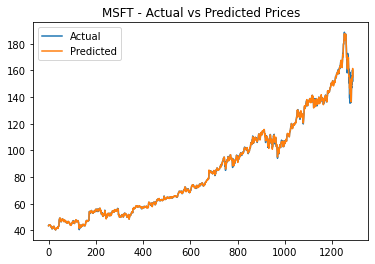

In [29]:
for stock in data['Stock'].unique():
    test_on_stock(linear_regression_model, stock)

## LSTM

In [8]:
def create_sequences(data, sequence_length, features, target):
    sequences = []
    targets = []
    
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]  # Get sequence of features
        target_value = data[i + sequence_length]  # Get target for the next time (Close)
        sequences.append(seq)
        targets.append(target_value)
    
    return np.array(sequences), np.array(targets)

# Step 6: Create sequences for training, validation, and testing
sequence_length = 60  # Define sequence length (60 days)

# For training data
X_train, y_train = create_sequences(training_X_scaled, sequence_length, ['Open', 'Low', 'High'], 'Close')

# For validation data
X_valid, y_valid = create_sequences(validation_X_scaled, sequence_length, ['Open', 'Low', 'High'], 'Close')

# For testing data
X_test, y_test = create_sequences(testing_X_scaled, sequence_length, ['Open', 'Low', 'High'], 'Close')

# Step 7: Reshape the data for LSTM (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], X_valid.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Check the shapes to confirm everything is correct
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (21052, 60, 3)
y_train shape: (21052, 3)
X_valid shape: (4462, 60, 3)
y_valid shape: (4462, 3)
X_test shape: (4469, 60, 3)
y_test shape: (4469, 3)


In [14]:
%%time
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

tf.get_logger().setLevel('ERROR')

# Define the LSTM model
lstm_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2), # Dropout layer (for regularization)
    Dense(units=1) # Predict a single value (Close price)
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_valid, y_valid), callbacks=[early_stopping])

Epoch 1/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 2/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 3.7578e-04 - val_loss: 0.0018
Epoch 3/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 2.6839e-04 - val_loss: 0.0015
Epoch 4/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 3.3774e-04 - val_loss: 0.0013
Epoch 5/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 2.5495e-04 - val_loss: 0.0011
Epoch 6/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 2.5684e-04 - val_loss: 0.0010
Epoch 7/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 2.1474e-04 - val_loss: 0.0010
Epoch 8/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 2.1044e-04 - val_loss: 0.0011
Epoch 9/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 2.0068e-04 - val_loss: 0.0012
Epoch 10/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 1.7430e-04 - val_loss: 0.0036
CPU times: user 4min 14s, sys: 14.6 s, total: 4min 29s
Wall time: 1min 52s


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Mean Squared Error for AAPL: 16.34529273506037
Root Mean Squared Error (RMSE) for AAPL: 4.042931205828312
R² Score for AAPL: 0.994125592161941


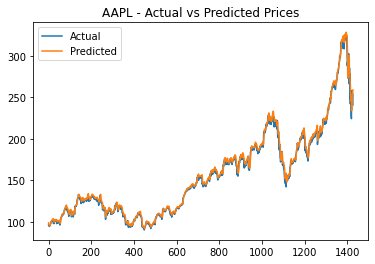

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Mean Squared Error for AMZN: 3172.808935284062
Root Mean Squared Error (RMSE) for AMZN: 56.327692437060314
R² Score for AMZN: 0.9785118193945144


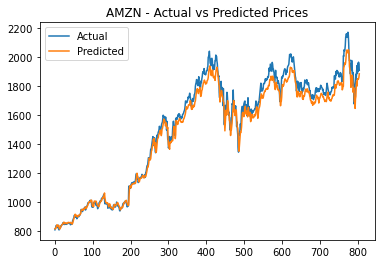

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Mean Squared Error for FB: 25.795050335537155
Root Mean Squared Error (RMSE) for FB: 5.078882784189566
R² Score for FB: 0.8878564640932549


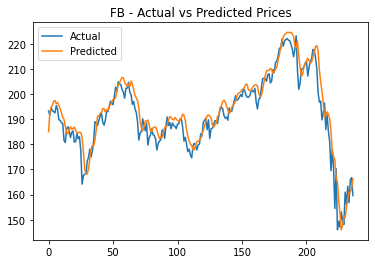

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Mean Squared Error for GOOGL: 593.5257687847044
Root Mean Squared Error (RMSE) for GOOGL: 24.362384300078357
R² Score for GOOGL: 0.9529275856676651


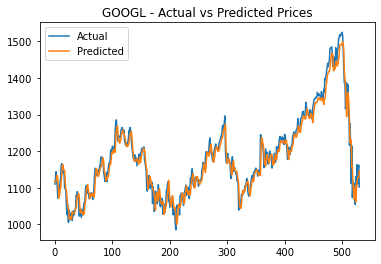

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Mean Squared Error for MSFT: 4.507283115685075
Root Mean Squared Error (RMSE) for MSFT: 2.123036296365438
R² Score for MSFT: 0.9964267522440416


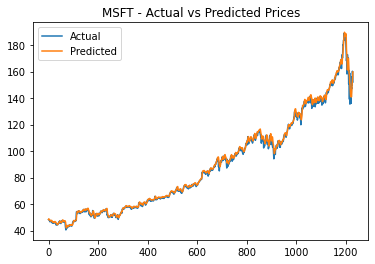

In [17]:
for stock in data['Stock'].unique():
    test_on_stock(lstm_model, stock, model_type='LSTM')

### Hyperparameter Tuning

In [24]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the hypermodel function
def build_model(hp):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), return_sequences=False),
        Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(units=1)
    ])

    # Compile the model with a tunable learning rate
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=0.0005, max_value=0.001, step=0.00025)),
                  loss='mean_squared_error')

    return model

In [26]:
# Initialize the Hyperband tuner
tuner = kt.Hyperband(build_model,
                     objective='val_loss',  # We want to minimize the validation loss
                     max_epochs=10,  # Limit the number of epochs for tuning
                     factor=3,  # Hyperband factor, controls the number of models to train
                     directory='kt_dir',  # Directory to store the tuner search results
                     project_name='lstm_tuning')

# Search the hyperparameter space (train the models)
tuner.search(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_valid, y_valid))

Trial 30 Complete [00h 03m 02s]
val_loss: 0.0009736758074723184

Best val_loss So Far: 0.0008786718244664371
Total elapsed time: 00h 47m 08s


In [27]:
# Get the best hyperparameters from the tuner
best_hyperparameters = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print(f"Best Hyperparameters: {best_hyperparameters}")

# Build the model with the best hyperparameters
best_lstm_model = tuner.hypermodel.build(best_hyperparameters)

# Train the model with the best hyperparameters
best_lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_valid, y_valid), callbacks=[early_stopping])

Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7f7b7a50c1c0>
Epoch 1/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 2/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - loss: 3.1812e-04 - val_loss: 0.0013
Epoch 3/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - loss: 2.3982e-04 - val_loss: 0.0012
Epoch 4/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - loss: 1.7175e-04 - val_loss: 0.0026
Epoch 5/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - loss: 2.8850e-04 - val_loss: 0.0010


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Mean Squared Error for AAPL: 29.02077950314747
Root Mean Squared Error (RMSE) for AAPL: 5.387093790082689
R² Score for AAPL: 0.9895700922985493


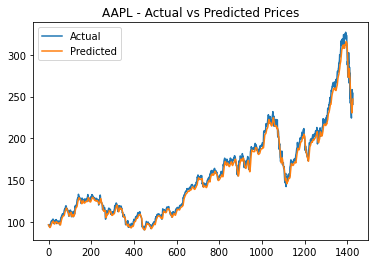

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Mean Squared Error for AMZN: 28043.35914937909
Root Mean Squared Error (RMSE) for AMZN: 167.46151542781132
R² Score for AMZN: 0.8100734149210896


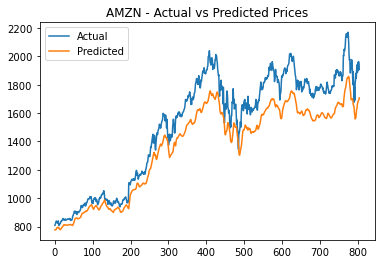

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Mean Squared Error for FB: 39.29456598085712
Root Mean Squared Error (RMSE) for FB: 6.268537786506285
R² Score for FB: 0.8291675529338542


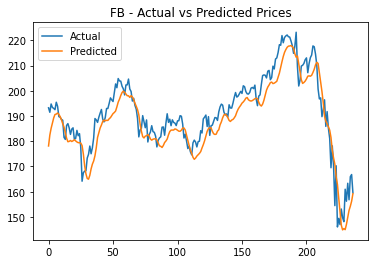

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Mean Squared Error for GOOGL: 7099.671198852381
Root Mean Squared Error (RMSE) for GOOGL: 84.25954663331854
R² Score for GOOGL: 0.43692644553575966


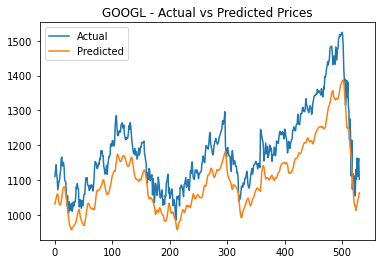

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Mean Squared Error for MSFT: 8.214501836189164
Root Mean Squared Error (RMSE) for MSFT: 2.8660952245501483
R² Score for MSFT: 0.9934877731220535


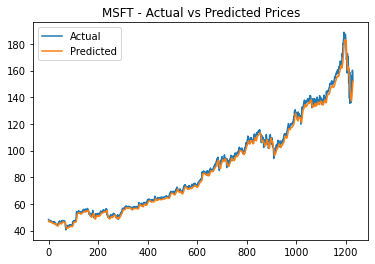

In [28]:
for stock in data['Stock'].unique():
    test_on_stock(best_lstm_model, stock, model_type='LSTM')

## Model Comparison

## Conclusion

## References